In [1]:
#----- imports --------
import tqdm
import torch
import wandb
import os
import tokenizers


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "eval_interval": 300,
    "max_iters": 3000, 
    "H": 16,
    "B": 64,
    "T": 128,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 6,
    "dropout": 0.4,
    "l2_penalty": 0.0,
    "n_layers": 6,
    "tokenizer_vocab_size": 4096,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v


# wandb.init(
#     project = "mini-shakespeare",
#     config = config
# )

In [2]:

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
print("length of dataset in lines: ", len(text.split('\n')))

length of dataset in lines:  40001


In [5]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
paths = ['input.txt']
tokenizer = tokenizers.ByteLevelBPETokenizer()

tokenizer.train(files=paths, vocab_size=tokenizer_vocab_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

tokenizer.save_model('.', 'shakespeare-bpe')



enc = tokenizer.encode("Romeo Romeo wherefore art thou Romeo?")
tokenizer.decode(enc.ids)


def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()




[262, 278, 83]
hello


In [7]:
print("length of dataset in characters: ", len(text))
print("length of dataset in tokens: ", len(encode(text)))
chars_per_token = len(text) / len(encode(text))
print("characters per token: ", chars_per_token)

length of dataset in characters:  1115394
length of dataset in tokens:  344152
characters per token:  3.2409923522164625


In [8]:

data = torch.tensor(encode(text), dtype=torch.long)
print(data.dtype)
print(data.size())
print(data.device)


torch.int64
torch.Size([344152])
cuda:0


In [9]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [10]:
train_data[:T+1]

tensor([ 676, 1201,   30,  203, 2347,  336, 2752,  807, 2307,   16,  679,  322,
         621,   18,  203,  203, 1236,   30,  203, 2543,   16,  621,   18,  203,
         203,  676, 1201,   30,  203,  570,  423,  400, 2058,  773, 1503,  292,
         969,  532,  292, 2797,  561,   35,  203,  203, 1236,   30,  203, 3667,
         499,  773,   18, 2058,  773,   18,  203,  203,  676, 1201,   30,  203,
         676,   16,  293,  509, 3997, 1422,  329, 3758, 1946,  292,  272, 1197,
          18,  203,  203, 1236,   30,  203,  672,  509,  671,   16,  336,  509,
         671,   18,  203,  203,  676, 1201,   30,  203,  949,  535, 1319,  365,
          16,  301,  336,  460,  360, 3149,  464,  417,  834, 1086,  313,   18,
         203,  767,  671,  263, 3319,   72, 1789,   35,  203,  203, 1236,   30,
         203,  693,  489, 1411,  303,  373,  671,   31,  542], device='cuda:0')

In [11]:
x = train_data[:T]
y = train_data[1:T+1]
for t in range(T):
    context = x[:t+1]
    target = y[t]
    # print("when we see the text", context, "we predict the next character is", target)

In [12]:
torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [13]:

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)
        attention_weights = self.dropout(attention_weights)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)

In [14]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)
        self.dropout = nn.Dropout(dropout)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return self.dropout(x)

In [15]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([64, 128, 16])

In [16]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [99]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [100]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
        self.block = nn.ModuleList([Block(H, C, n_heads)])
    
    def forward(self, idx, targets=None, return_residual_layer=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if return_residual_layer is not None and i == return_residual_layer:
                return x

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss


    def generate(self, idx, max_new_tokens, temperature=1.0):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] / temperature # all batches, last token, all probabilities
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    

model = GPT(n_layers)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

torch.Size([64, 128, 4096])
tensor(8.6521, device='cuda:0', grad_fn=<NllLossBackward0>)


(tensor([[[ 0.6251,  0.4230,  0.1617,  ...,  1.1294,  0.3573,  2.3344],
          [ 1.4492, -1.0383, -0.5206,  ...,  1.0151, -0.7488, -0.0295],
          [ 2.1409, -1.4470, -1.1828,  ..., -0.9876, -0.4359,  0.0991],
          ...,
          [ 0.4630, -0.5371, -0.2835,  ..., -0.7094, -0.8055,  0.3563],
          [-0.0267, -0.9003,  0.2178,  ...,  1.4226,  1.2810,  1.3825],
          [ 0.6457, -0.9237, -0.0476,  ...,  0.2930, -0.1577,  0.8994]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None)

In [20]:
model

GPT(
  (token_embedding_table): Embedding(4096, 256)
  (position_embedding_table): Embedding(128, 256)
  (lm_head): Linear(in_features=256, out_features=4096, bias=True)
  (layers): ModuleList(
    (0-5): 6 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (query): Linear(in_features=256, out_features=16, bias=False)
            (key): Linear(in_features=256, out_features=16, bias=False)
            (value): Linear(in_features=256, out_features=16, bias=False)
            (dropout): Dropout(p=0.4, inplace=False)
          )
        )
        (combine_heads): Linear(in_features=96, out_features=256, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=768, bias=True)
          (1): ReLU()
          (2): Linear(in_features=768, out_features=256, bias=True)
          (3): Dropout(p=0.4, inplace=False)
     

In [21]:
# logits, loss = self(idx[:,-T:])

idx = torch.zeros(1, 1).long()
idx[:,-T:]

tensor([[0]], device='cuda:0')

In [22]:
model.token_embedding_table.weight.device

device(type='cuda', index=0)

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [24]:
eval_iters = 10
eval_interval = 300
@torch.no_grad()
def estimate_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = eval_iters
        if is_last and split == 'val':  # increase last eval to mitigate noise
            real_iters *= 10 
        losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean() / chars_per_token
    model.train()
    return out
    

In [25]:
# get the number of parameters
n_params = sum(p.numel() for p in model.parameters())
parameter_to_data_ratio = n_params / len(train_data)
print(f"{parameter_to_data_ratio=}")

parameters = []
for name, param in model.named_parameters():
    parameters.append({"name": name, "params": param.numel()})

# sort parameters by size
sorted_parameters = sorted(parameters, key=lambda x: x["params"], reverse=True)
for p in sorted_parameters:
    print(f"{p['name']}: {p['params']}")

parameter_to_data_ratio=18.05015884495183
token_embedding_table.weight: 1048576
lm_head.weight: 1048576
layers.0.ff.net.0.weight: 196608
layers.0.ff.net.2.weight: 196608
layers.1.ff.net.0.weight: 196608
layers.1.ff.net.2.weight: 196608
layers.2.ff.net.0.weight: 196608
layers.2.ff.net.2.weight: 196608
layers.3.ff.net.0.weight: 196608
layers.3.ff.net.2.weight: 196608
layers.4.ff.net.0.weight: 196608
layers.4.ff.net.2.weight: 196608
layers.5.ff.net.0.weight: 196608
layers.5.ff.net.2.weight: 196608
block.0.ff.net.0.weight: 196608
block.0.ff.net.2.weight: 196608
position_embedding_table.weight: 32768
layers.0.attention.combine_heads.weight: 24576
layers.1.attention.combine_heads.weight: 24576
layers.2.attention.combine_heads.weight: 24576
layers.3.attention.combine_heads.weight: 24576
layers.4.attention.combine_heads.weight: 24576
layers.5.attention.combine_heads.weight: 24576
block.0.attention.combine_heads.weight: 24576
lm_head.bias: 4096
layers.0.attention.heads.0.query.weight: 4096
laye

In [52]:
num_params = sum([p.numel() for p in model.parameters()])

for steps in tqdm.tqdm(range(max_iters)):
    xb, yb = get_batch('train')
    # loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    # l2 regularization
    l2 = sum(p.pow(2).sum() for p in model.parameters()) / num_params
    loss = loss + l2 * l2_penalty

    loss.backward()
    optimizer.step()
    if steps % eval_interval == 0:
        losses = estimate_loss()
        print({"train": losses['train'].item(), "val": losses['val'].item()})
        # wandb.log({"train": losses['train'].item(), "val": losses['val'].item(), "l2":l2})

losses = estimate_loss(is_last=True)
# wandb.log({"train": losses['train'].item(), "val": losses['val'].item()})
# wandb.finish()


  0%|          | 4/3000 [00:00<06:11,  8.07it/s]

{'train': 2.4629106521606445, 'val': 2.428684949874878}


 10%|█         | 307/3000 [00:12<01:52, 23.88it/s]

{'train': 1.3153401613235474, 'val': 1.4888041019439697}


 20%|██        | 605/3000 [00:23<01:40, 23.73it/s]

{'train': 1.1827619075775146, 'val': 1.4529527425765991}


 30%|███       | 905/3000 [00:34<01:27, 23.95it/s]

{'train': 1.112679123878479, 'val': 1.4225417375564575}


 40%|████      | 1204/3000 [00:44<01:22, 21.83it/s]

{'train': 1.0462663173675537, 'val': 1.4234868288040161}


 50%|█████     | 1506/3000 [00:55<01:03, 23.41it/s]

{'train': 0.9836072325706482, 'val': 1.4308961629867554}


 60%|██████    | 1805/3000 [01:05<00:50, 23.67it/s]

{'train': 0.9270840287208557, 'val': 1.4367361068725586}


 70%|███████   | 2105/3000 [01:15<00:38, 23.42it/s]

{'train': 0.8723002672195435, 'val': 1.4640569686889648}


 80%|████████  | 2404/3000 [01:25<00:27, 21.61it/s]

{'train': 0.8218696713447571, 'val': 1.4826096296310425}


 90%|█████████ | 2704/3000 [01:44<00:31,  9.37it/s]

{'train': 0.7805870771408081, 'val': 1.5116276741027832}


100%|██████████| 3000/3000 [02:09<00:00, 23.19it/s]


In [53]:
estimate_loss()

{'train': tensor(0.7425, device='cuda:0'),
 'val': tensor(1.5142, device='cuda:0')}

In [87]:
xb, yb = get_batch('train')

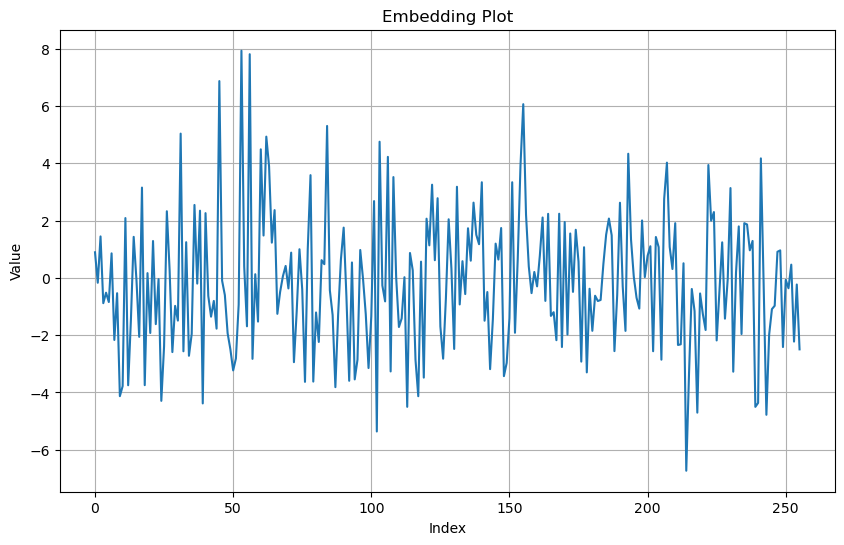

In [98]:

embedding = model.forward(xb, return_residual_layer=5)[0][60] # batch 0, word 64
import matplotlib.pyplot as plt

# Extract the embedding values for plotting
embedding_values = embedding.cpu().detach().numpy()

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(embedding_values)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Embedding Plot')
plt.grid(True)
plt.show()





In [ ]:
quote = '''BARNARDO:
I will slay thee Horatio!

HORATIO:
'''
# tokenize the quote
quote_encoded = encode(quote)
print(len(quote_encoded))

# pad the quote to the length of the model
quote_encoded = quote_encoded + [0]*(T-len(quote_encoded))

quote_encoded

24


[38,
 376,
 50,
 515,
 51,
 30,
 203,
 45,
 389,
 753,
 316,
 416,
 548,
 275,
 308,
 624,
 5,
 203,
 203,
 1321,
 37,
 586,
 30,
 203,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
len(quote_encoded)

128

In [65]:
test_idx = torch.zeros(1, T).long()
print(decode(
    model.generate(idx=test_idx, temperature=0.15, max_new_tokens=T)[0].tolist()
)[T:])

at themselves; and theirs: they had fought together,
Though they themselves did buded them.

COMINIUS:
They are not, they are going to be consul.

MENENIUS:
I have wounds me, and they are friends, and
The gods themselves are rising iron.

MENENIUS:
I prithee now, I have heard
Hear me speak, I
